# HIFI-GAN

In [163]:
import json
import glob
import os
import argparse
import json
import torch

import soundfile as sf
from scipy.io.wavfile import write, read
from librosa.filters import mel
from IPython.display import display, Audio

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

# Utils

In [164]:
class Config:
    MAX_WAV_VALUE = 32768.0
    LRELU_SLOPE = 0.1
    n_fft = 1024
    num_freq = 1025
    num_mels = 80
    sampling_rate = 22050 
    hop_size = 256 
    win_size = 1024
    fmin = 0 
    fmax = 8000
    segment_size = 8192
    
    seed = 1234
    
    upsample_rates = [8,8,4]
    upsample_kernel_sizes = [16,16,8]
    upsample_initial_channel = 256
    resblock_kernel_sizes = [3,5,7]
    resblock_dilation_sizes = [[1,2], [2,6], [3,12]]
    resblock_initial_channel = 128

config = Config()

torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.manual_seed(config.seed)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [165]:
def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)

def init_weights(m, mean=0.0, std=0.01):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)

# Mel Spectrogram

In [166]:
def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

In [173]:
def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    mel_spec = mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
    mel_basis = torch.from_numpy(mel_spec).float().to(y.device)
    hann_window = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window,
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)

    spec = torch.sqrt(spec.float().pow(2)+(1e-9))

    spec = torch.matmul(mel_basis, spec.T)
    spec = spectral_normalize_torch(spec).permute(2,1,0)

    return spec

In [168]:
def plot_spectrogram(spectrogram, text=None, x_label="Time", y_label="Value", figsize=(16, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    if text:
        plt.title(text)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar(im, ax=ax, use_gridspec=True)
    
    fig.canvas.draw()
    plt.show()

    return

# Model

In [169]:
class ResBlock(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3)):
        super(ResBlock, self).__init__()
        self.h = h
        self.convs = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1])))
        ])
        self.convs.apply(init_weights)

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, 0.1)
            xt = c(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs:
            remove_weight_norm(l)

<img src="generator.PNG" width="100%">

<img src="hifi_gan.PNG" width="100%">

In [170]:
class Generator(torch.nn.Module):
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(h.upsample_initial_channel//(2**i), h.upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = h.upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                self.resblocks.append(ResBlock(h, ch, k, d))

        self.conv_post = weight_norm(Conv1d(ch, 1, 7, 1, padding=3))
        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        x = self.conv_pre(x)
        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, config.LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for l in self.ups:
            remove_weight_norm(l)
        for l in self.resblocks:
            l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        remove_weight_norm(self.conv_post)

In [118]:
generator = Generator(config)
generator

Generator(
  (conv_pre): Conv1d(80, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(128, 64, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): ResBlock(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      )
    )
    (1): ResBlock(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
        (1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(12,), dilation=(6,))
      )
    )
    (2): ResBlock(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (1): Conv1d(1

<img src="discriminator.png" width="100%">

In [192]:
class DiscriminatorP(torch.nn.Module):
    def __init__(self, period, kernel_size=5, stride=3, use_spectral_norm=False):
        super(DiscriminatorP, self).__init__()
        self.period = period
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv2d(1, 32, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(32, 128, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(128, 512, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(512, 1024, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(1024, 1024, (kernel_size, 1), 1, padding=(2, 0))),
        ])
        self.conv_post = norm_f(Conv2d(1024, 1, (3, 1), 1, padding=(1, 0)))

    def forward(self, x):
        fmap = []

        # 1d to 2d
        b, c, t = x.shape
        if t % self.period != 0: # pad first
            n_pad = self.period - (t % self.period)
            x = F.pad(x, (0, n_pad), "reflect")
            t = t + n_pad
        x = x.view(b, c, t // self.period, self.period)
        print(x.shape)

        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, config.LRELU_SLOPE)
            fmap.append(x)
            print(x.shape)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class MultiPeriodDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiPeriodDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([
            DiscriminatorP(2),
            DiscriminatorP(3),
            DiscriminatorP(5),
            DiscriminatorP(7),
            DiscriminatorP(11),
        ])

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        for i, d in enumerate(self.discriminators):
            y_d_r, fmap_r = d(y)
            y_d_g, fmap_g = d(y_hat)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs


class DiscriminatorS(torch.nn.Module):
    def __init__(self, use_spectral_norm=False):
        super(DiscriminatorS, self).__init__()
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv1d(1, 128, 15, 1, padding=7)),
            norm_f(Conv1d(128, 128, 41, 2, groups=4, padding=20)),
            norm_f(Conv1d(128, 256, 41, 2, groups=16, padding=20)),
            norm_f(Conv1d(256, 512, 41, 4, groups=16, padding=20)),
            norm_f(Conv1d(512, 1024, 41, 4, groups=16, padding=20)),
            norm_f(Conv1d(1024, 1024, 41, 1, groups=16, padding=20)),
            norm_f(Conv1d(1024, 1024, 5, 1, padding=2)),
        ])
        self.conv_post = norm_f(Conv1d(1024, 1, 3, 1, padding=1))

    def forward(self, x):
        fmap = []
        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, config.LRELU_SLOPE)
            fmap.append(x)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class MultiScaleDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiScaleDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([
            DiscriminatorS(use_spectral_norm=True),
            DiscriminatorS(),
            DiscriminatorS(),
        ])
        self.meanpools = nn.ModuleList([
            AvgPool1d(4, 2, padding=2),
            AvgPool1d(4, 2, padding=2)
        ])

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        for i, d in enumerate(self.discriminators):
            if i != 0:
                y = self.meanpools[i-1](y)
                y_hat = self.meanpools[i-1](y_hat)
            y_d_r, fmap_r = d(y)
            y_d_g, fmap_g = d(y_hat)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs

<img src="frequency_response.png" width="100%">

## Losses

Discriminator loss: $
\begin{align}
    \mathcal{L}_{Adv}(D; G) &= \mathbb{E}_{(x, s)} \Bigg[(D(x)-1)^2 + (D(G(s)))^2\Bigg]\\
\end{align}
$
---

Generator loss: $
\begin{align}
    \mathcal{L}_{Adv}(G; D) &= \mathbb{E}_{s} \Bigg[(D(G(s))-1)^2\Bigg]
\end{align}
$
---
---

Feature matching loss: $
\begin{align}
    \mathcal{L}_{FM}(G; D) &= \mathbb{E}_{(x, s)} \Bigg[\sum_{i=1}^{T}\frac{1}{N_{i}}||D^i(x)-D^i(G(s))||_{1}\Bigg]
\end{align}
$
---

Mel loss: $\begin{align}
    \mathcal{L}_{Mel}(G) &= \mathbb{E}_{(x, s)} \Bigg[||\phi(x)-\phi(G(s))||_{1}\Bigg]
\end{align}$
---
---

Total generator loss: $
\begin{align}
    \mathcal{L}_{G} &= \mathcal{L}_{Adv}(G; D) + \lambda_{fm}\mathcal{L}_{FM}(G; D) + \lambda_{mel}\mathcal{L}_{Mel}(G)
\end{align}
$
---

Total discriminator loss: $
\begin{align}
    \mathcal{L}_{D} &= \mathcal{L}_{Adv}(D; G)
\end{align}
$
---

In [171]:
def discriminator_loss(disc_real_outputs, disc_generated_outputs):
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
        r_loss = torch.mean((1-dr)**2)
        g_loss = torch.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs):
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = torch.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses

def feature_loss(fmap_r, fmap_g):
    loss = 0
    for dr, dg in zip(fmap_r, fmap_g):
        for rl, gl in zip(dr, dg):
            loss += torch.mean(torch.abs(rl - gl))

    return loss*2

## Compute loss

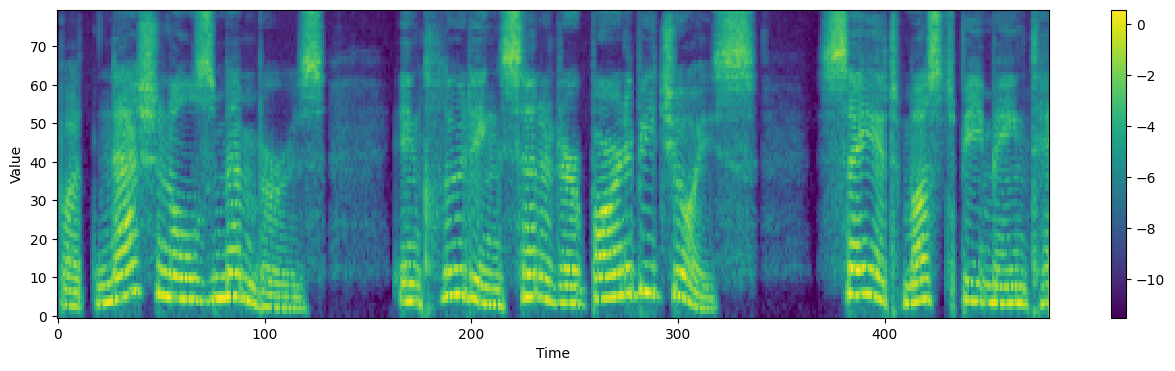

In [174]:
sr, wav = read('00000.wav')
wav = wav / config.MAX_WAV_VALUE

y = torch.FloatTensor(wav).unsqueeze(0).to(device)
y = y[:,:config.segment_size * (y.size(-1)//config.segment_size) ]


x = mel_spectrogram(
            y, 
            n_fft=config.n_fft,
            num_mels=config.num_mels, 
            sampling_rate=config.sampling_rate, 
            hop_size=config.hop_size, 
            win_size=config.win_size, 
            fmin=config.fmin, 
            fmax=config.fmax
        )
y = y.unsqueeze(0)

plot_spectrogram(x[0])

In [193]:
generator = Generator(config).to(device)
mpd = MultiPeriodDiscriminator().to(device)
msd = MultiScaleDiscriminator().to(device)

y_g_hat = generator(x)
y_g_hat_mel = mel_spectrogram(
    y_g_hat.squeeze(1), 
    n_fft=config.n_fft,
    num_mels=config.num_mels, 
    sampling_rate=config.sampling_rate, 
    hop_size=config.hop_size, 
    win_size=config.win_size, 
    fmin=config.fmin, 
    fmax=config.fmax
)

# MPD
y_df_hat_r, y_df_hat_g, _, _ = mpd(y, y_g_hat.detach())
loss_disc_f, losses_disc_f_r, losses_disc_f_g = discriminator_loss(y_df_hat_r, y_df_hat_g)
print (f'MDP loss: {loss_disc_f}')

# MSD
y_ds_hat_r, y_ds_hat_g, _, _ = msd(y, y_g_hat.detach())
loss_disc_s, losses_disc_s_r, losses_disc_s_g = discriminator_loss(y_ds_hat_r, y_ds_hat_g)
print (f'MSD loss: {loss_disc_s}')

loss_mel = F.l1_loss(x, y_g_hat_mel)
print (f'Mel loss: {loss_mel}')

y_df_hat_r, y_df_hat_g, fmap_f_r, fmap_f_g = mpd(y, y_g_hat)
y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = msd(y, y_g_hat)

loss_fm_f = feature_loss(fmap_f_r, fmap_f_g)
loss_fm_s = feature_loss(fmap_s_r, fmap_s_g)
loss_gen_f, losses_gen_f = generator_loss(y_df_hat_g)
loss_gen_s, losses_gen_s = generator_loss(y_ds_hat_g)
print (f'MDP feature loss: {loss_fm_f}', f'MSD feature loss: {loss_fm_s}', sep='\n')
print (f'MDP generator_loss: {loss_gen_f}', f'MSD generator_loss: {loss_gen_s}', sep='\n')

torch.Size([1, 1, 61440, 2])
torch.Size([1, 32, 20480, 2])
torch.Size([1, 128, 6827, 2])
torch.Size([1, 512, 2276, 2])
torch.Size([1, 1024, 759, 2])
torch.Size([1, 1024, 759, 2])
torch.Size([1, 1, 61440, 2])
torch.Size([1, 32, 20480, 2])
torch.Size([1, 128, 6827, 2])
torch.Size([1, 512, 2276, 2])
torch.Size([1, 1024, 759, 2])
torch.Size([1, 1024, 759, 2])
torch.Size([1, 1, 40960, 3])
torch.Size([1, 32, 13654, 3])
torch.Size([1, 128, 4552, 3])
torch.Size([1, 512, 1518, 3])
torch.Size([1, 1024, 506, 3])
torch.Size([1, 1024, 506, 3])
torch.Size([1, 1, 40960, 3])
torch.Size([1, 32, 13654, 3])
torch.Size([1, 128, 4552, 3])
torch.Size([1, 512, 1518, 3])
torch.Size([1, 1024, 506, 3])
torch.Size([1, 1024, 506, 3])
torch.Size([1, 1, 24576, 5])
torch.Size([1, 32, 8192, 5])
torch.Size([1, 128, 2731, 5])
torch.Size([1, 512, 911, 5])
torch.Size([1, 1024, 304, 5])
torch.Size([1, 1024, 304, 5])
torch.Size([1, 1, 24576, 5])
torch.Size([1, 32, 8192, 5])
torch.Size([1, 128, 2731, 5])
torch.Size([1, 512,

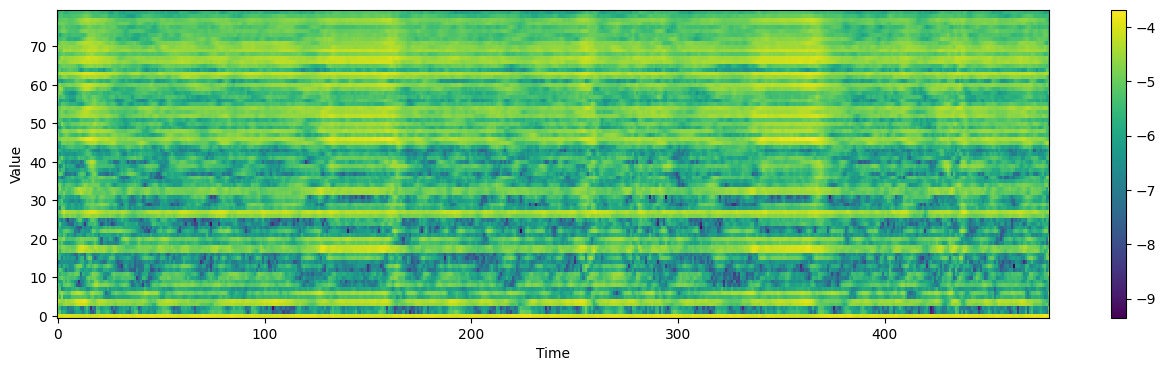

In [179]:
plot_spectrogram(y_g_hat_mel.cpu().detach().numpy()[0])

In [182]:
checkpoint_file = 'generator'
state_dict_g = torch.load(checkpoint_file, map_location=device)
generator.load_state_dict(state_dict_g['generator'])
y_g_hat = generator(x)

y_g_hat_mel = mel_spectrogram(
    y_g_hat.squeeze(1), 
    n_fft=config.n_fft,
    num_mels=config.num_mels, 
    sampling_rate=config.sampling_rate, 
    hop_size=config.hop_size, 
    win_size=config.win_size, 
    fmin=config.fmin, 
    fmax=config.fmax
)

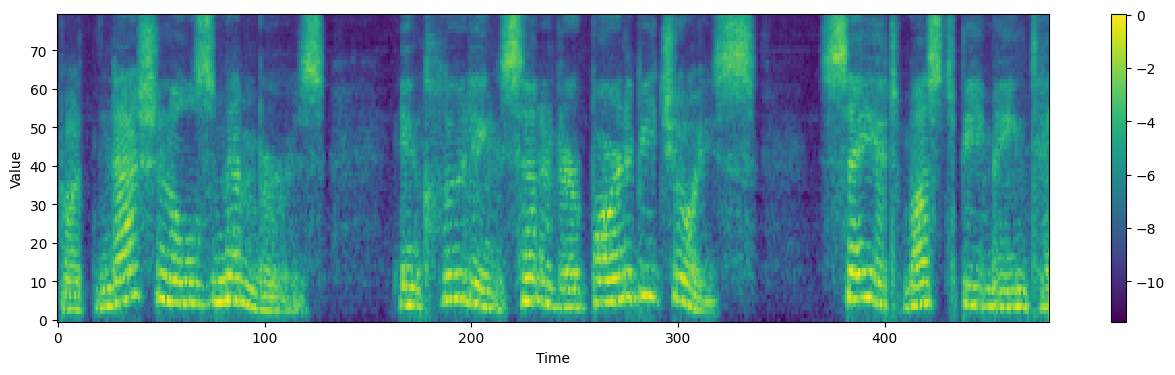

In [183]:
plot_spectrogram(y_g_hat_mel.cpu().detach().numpy()[0])

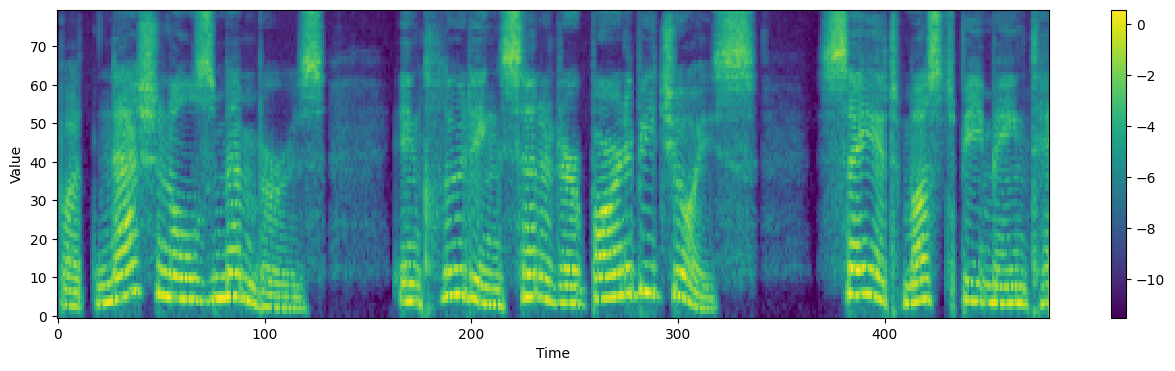

In [184]:
plot_spectrogram(x[0])

## Inference

In [185]:
checkpoint_file = 'generator'
def inference(wav):
    generator = Generator(config).to(device)

    state_dict_g = torch.load(checkpoint_file, map_location=device)
    generator.load_state_dict(state_dict_g['generator'])

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        wav = wav / config.MAX_WAV_VALUE
        wav = torch.FloatTensor(wav).unsqueeze(0).to(device)
        x = mel_spectrogram(
            wav, 
            n_fft=1024,
            num_mels=80, 
            sampling_rate=22050, 
            hop_size=256, 
            win_size=1024, 
            fmin=0, 
            fmax=8000
        )
        
        y_g_hat = generator(x)
        audio = y_g_hat.squeeze()
        audio = audio * config.MAX_WAV_VALUE
        audio = audio.cpu().numpy().astype('int16')

        return audio
        

In [186]:
sr, wav = read('00000.wav')

In [187]:
audio = inference(wav)

Removing weight norm...


In [191]:
display(Audio(audio, rate=22050))